## 6.3 주성분 분석

목표: 차원 축소에 대해 이해하고 대표적인 차원 축소 알고리즘 중 하나인 PCA(주성분 분석) 모델 만들기

### 차원과 차원 축소

데이터가 가진 속성을 특성이라 부른다. 과일 사진의 경우 10,000개의 픽셀이 있기 때문에 10,000개의 특성이 있는 셈이다.

머신러닝에서는 이런 특성을 차원(dimension)이라고 부른다.

결국 차원을 줄이면 저장 공간을 크게 절약할 수 있다.

### 주성분 분석 (Principal Component Analysis; PCA) 소개

주석분 분석은 데이터에 있는 분산이 큰 방향을 찾는 것으로 이해할 수 있다.

분산이 큰 방향이란 데이터를 잘 표현하는 어떤 벡터라고 생각할 수 있다.

### PCA 클래스

In [3]:
import numpy as np

fruits    = np.load("../data/fruits_300.npy")
fruits_2d = fruits.reshape(-1, 100*100)

In [5]:
# 결과 이미지 확인

import matplotlib.pyplot as plt

def draw_fruits(arr, ratio=1):
    n = len(arr)
    
    # 한 줄에 10개 씩 이미지 그리기. 샘플 개수를 10으로 나누어 전체 행 개수를 계산
    rows = int(np.ceil(n/10))

    # 행이 1개이면 열의 개수는 샘플 개수, 그렇지 않으면 10개
    cols = n if rows < 2 else 10

    fig, axs = plt.subplots(rows, cols, figsize=(cols*ratio, rows*ratio), squeeze=False)

    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:
                axs[i, j].imshow(arr[i*10+j], cmap="gray_r")

            axs[i,j].axis("off")

    plt.show()
    

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50) # n_components 매겨변수에 주성분의 개수를 지정해야 한다.
pca.fit(fruits_2d)

PCA(n_components=50)

In [6]:
print(pca.components_.shape)

(50, 10000)


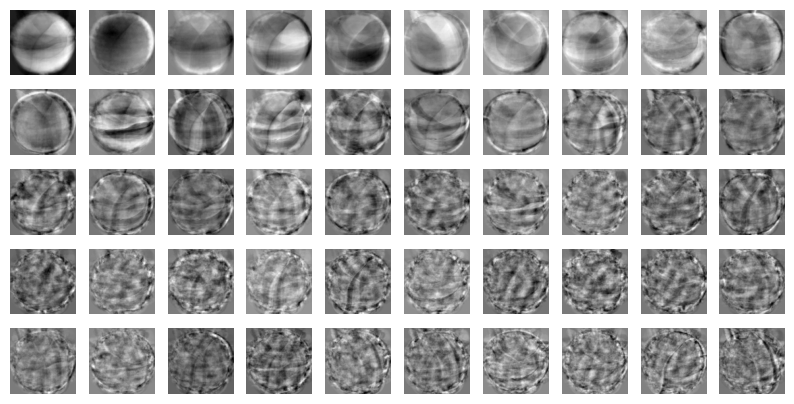

In [8]:
draw_fruits(pca.components_.reshape(-1,100,100))

이 주성분은 원본 데이터에서 가장 분사나이 큰 방향을 순서대로 나타낸 것 임.

In [9]:
print(fruits_2d.shape)

(300, 10000)


In [10]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 50)


주성분 분석을 통해 50개의 특성을 가진 데이터로 변환

### 원본 데이터 재구성

앞에서 10,000개의 특성을 50개로 줄였다. 이로 인해 어느 정도 손실이 발생할 수 밖에 없다.

하지만 최대한 분산이 큰 방향으로 데이터를 투영했기 때문에 원본 데이터를 상당 부분 재구성할 수 있다.

PCA 클래스는 이를 위해 inverse_transform() 메서드를 제공한다. 앞서 50개의 차원으로 축소한 fruits_pca 데이터를 전달해 10,000개의 특성을 복원하겠다.

In [11]:
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


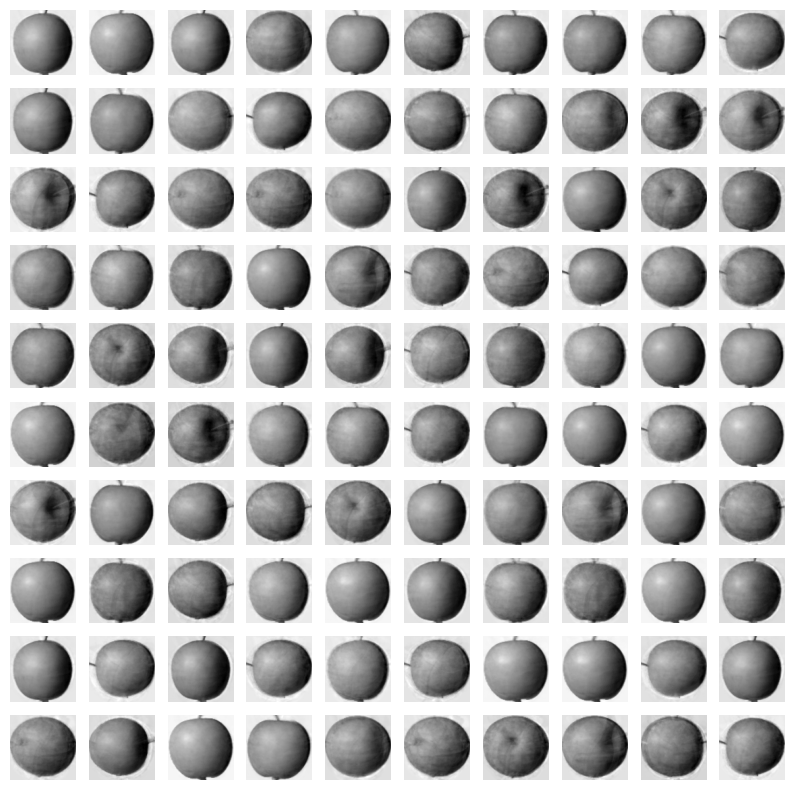

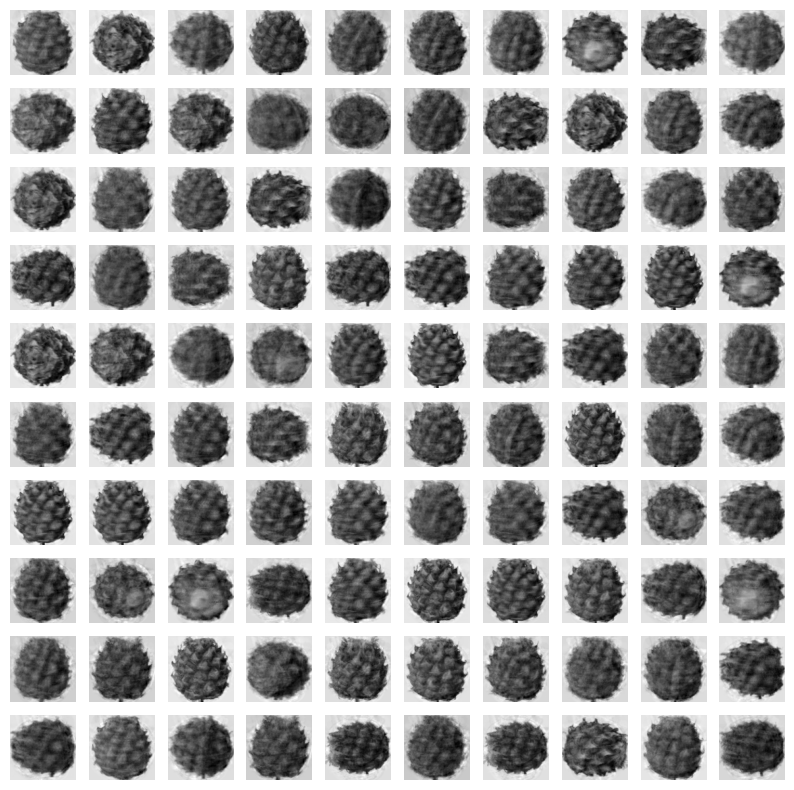

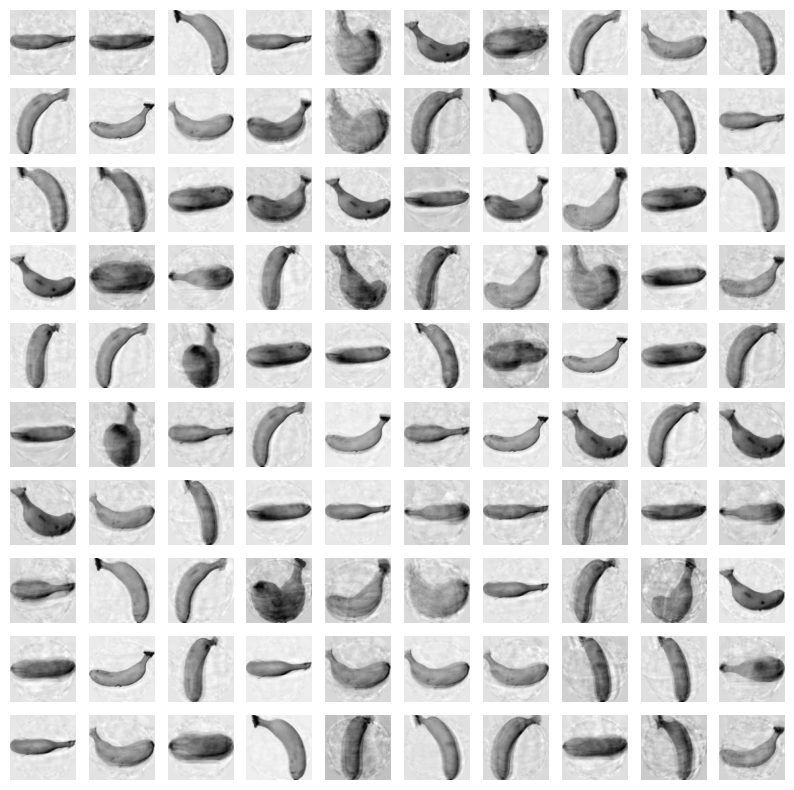

In [12]:
fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)
for start in [0, 100, 200]:
    draw_fruits(fruits_reconstruct[start:start+100])
    print("\n")

흐린 부분이 없지 않아 있지만 그럼에도 불구하고 잘 복원하였다.

만약 주성분을 최대로 사용했다면 완벽하게 원본 데이터를 재구성할 수 있었을 것이다.

그럼 50개의 특성은 얼마나 분산을 보존하고 있는 것 일까?

### 설명된 분산

주성분이 원본 데이터의 분산을 얼마나 잘 나타내는지 기록한 값을 "설명된 분산(explained variance)라고 한다.

당연히 첫 번째 주성분의 설명된 분산이 가장 크다. 이 분산 비율을 모두 더하면 40개의 주성분으로 표현하고 있는 총 분산 비율을 덕을 수 있다.

In [13]:
print(np.sum(pca.explained_variance_ratio_))

0.9215676353847888


92%로가 넘는 분산을 유지하고 있다.

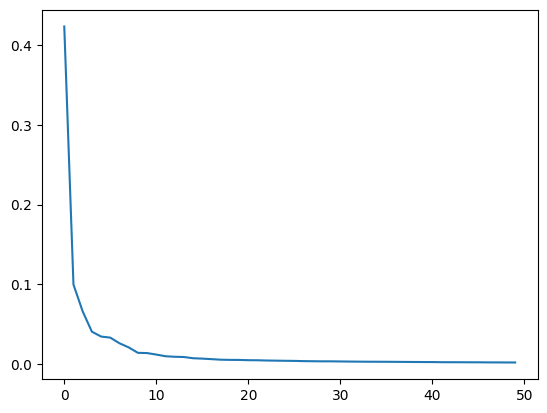

In [14]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

10개의 주성분이 대부분의 분산을 표현하고 있고, 그 다음부터는 각 주성분이 설명하고 있는 분산은 작다.

### 다른 알고리즘과 함께 사용하기

과일 사진 원본 데이터와 PCA로 축소한 데이터를 지도 학습에 적용해 보고 어떤 차이가 있는지 확인해보자.

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [18]:
target = np.array([0]*100+[1]*100+[2]*100)

In [20]:
from sklearn.model_selection import cross_validate

scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores["test_score"]))
print(np.mean(scores["fit_time"]))

0.9966666666666667
0.5582645416259766


교차 검증의 점수가 매우 높다. 특성이 10,000개나 되기 때문에 300개의 샘플에서는 금방 과대적합된 모델을 만들기 쉽다.

fit_time 을 통해 교차 검증 포드의 훈련 시간이 기록되어 있는데, 0.55초 소요되었다.

In [21]:
# PCA 적용 후

scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores["test_score"]))
print(np.mean(scores["fit_time"]))

1.0
0.016548919677734374


50개 특성만을 사용 했는데 정확도가 100%로 이고, 훈련 속도가 0.016초로 엄청나가 계산 속도가 향상되었다.

PCA로 훈련 데이터의 차원을 축소하면 저장 공간뿐만 아니라 머신러닝 모델의 훈련 속도도 높일 수 있다

In [23]:
pca = PCA(n_components=0.5) # 주성분의 개수 말고, 분산의 비율을 입력 가능
pca.fit(fruits_2d)

PCA(n_components=0.5)

In [24]:
print(pca.n_components_)

2


In [26]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [29]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores["test_score"]))
print(np.mean(scores["fit_time"]))

0.9933333333333334
0.01891746520996094


/home/usr01/.local/share/virtualenvs/hongong-QbFHym6F/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/usr01/.local/share/virtualenvs/hongong-QbFHym6F/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

In [31]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)
print(np.unique(km.labels_, return_counts=True))

(array([0, 1, 2], dtype=int32), array([110,  99,  91]))


/home/usr01/.local/share/virtualenvs/hongong-QbFHym6F/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


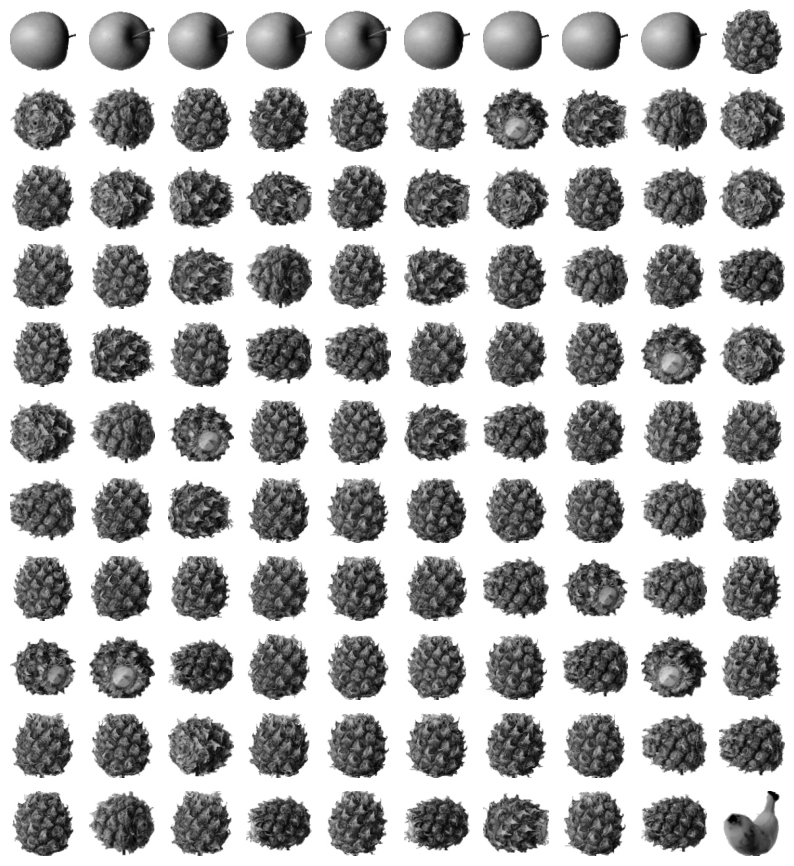

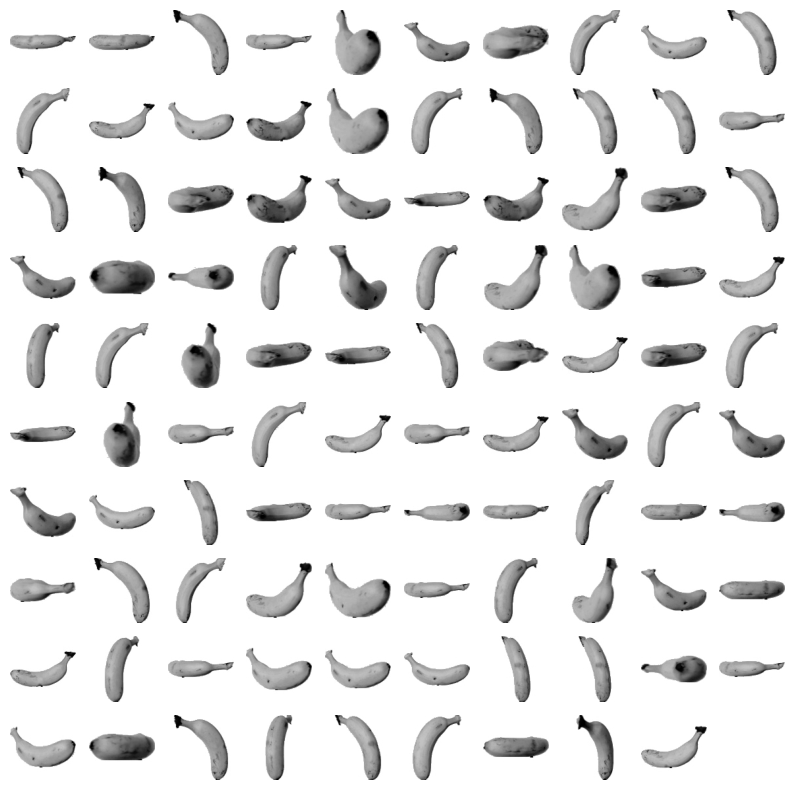

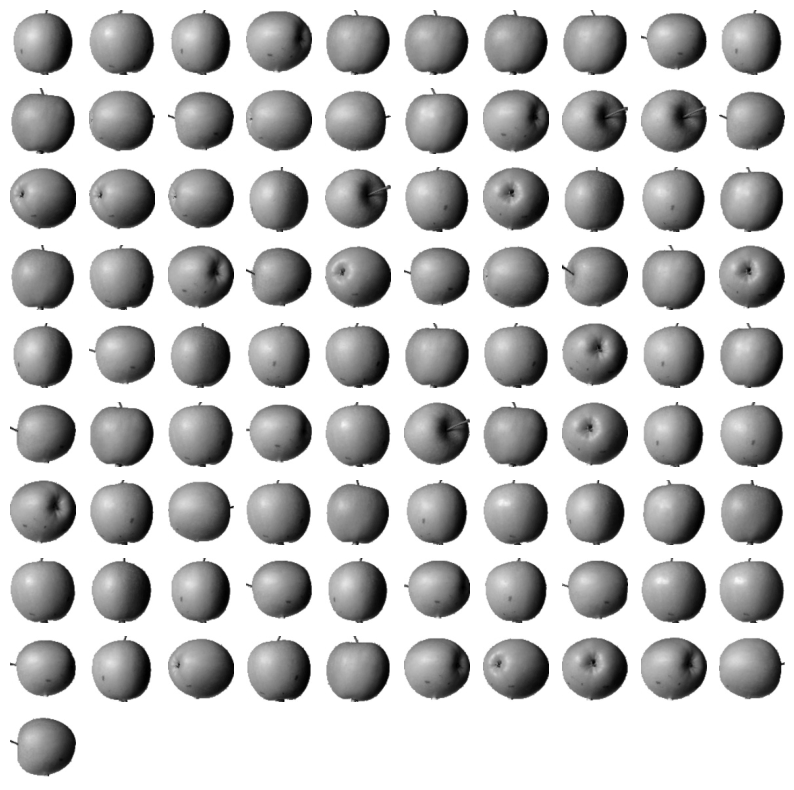

In [32]:
for label in range(3):
    draw_fruits(fruits[km.labels_==label])
    print("\n")

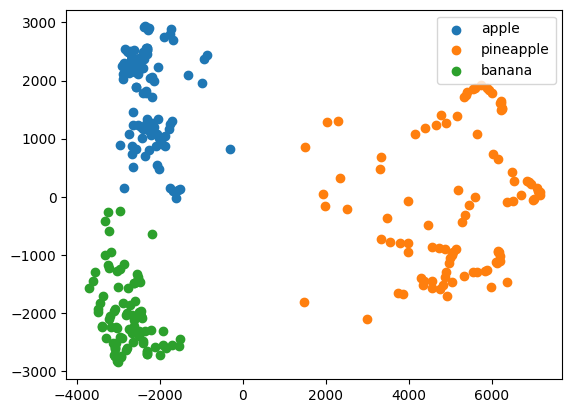

In [34]:
# 산점도

for label in range(3):
    data = fruits_pca[km.labels_==label]
    plt.scatter(data[:,0], data[:,1])
plt.legend(["apple", "pineapple", "banana"])
plt.show()